# Training and Deploying a Cat vs Dog Classifier using Caffe

In this tutorial, I'll walk through using caffe in python to build a cat vs dog classifier from scratch.

### 0. Data Prep 

Before we get started with this tutorial, let's get the file structure set up to match the directories that this notebook will be looking for. After we set everything up, you can simply run through this entire notebook sequentially and everything should run smoothly.

First, download the dataset from the following link:  
https://www.kaggle.com/c/dogs-vs-cats/data (grab the test1.zip file)

Unzip the file and place it into a folder called "data".  

Next, download the following zip file, which contains a snapshot of the model I trained with ~90% accuracy:  
https://drive.google.com/file/d/1GwqSP_bTuCCEwpTASGMIM5cq0Q3COiK7/view?usp=sharing

Also included in the zip are a few numpy files and test images. Don't worry about what all these files are for now, I'll explain everything as we proceed through the tutorial.  

If everything went well, your file structure should look like this:

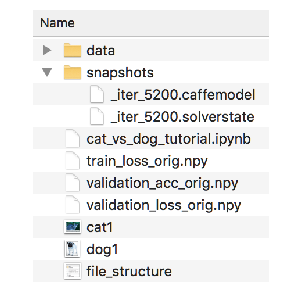

In [1]:
import cv2
from matplotlib import pyplot as plt

%matplotlib inline

img = cv2.imread('file_structure.png', cv2.IMREAD_COLOR)
fig, ax1 = plt.subplots(figsize=(8, 5))
plt.axis('off')
plt.imshow(img)
plt.show()

### 1. Image Preprocessing and Database Creation

In the first of many preparation steps, we have to preprocess our images so that they are all the same size and contrast enhanced via histogram equalization. Further preprocessing steps can be done, but we'll keep it simple for now.

After each image is preprocessed, we place it into an LMDB (the kind of database that caffe uses). We are going to randomly assign the image to either the training database or the validation database. 80% of the images will be placed into the training database, and 20% into the validation database. Note that images will be stored in the B,G,R format instead of the R,G,B. The reason for this is to stay consistent with OpenCV, and other architectures such as CaffeNet.

Note that we also need to calculate an image mean for all images in the training database. To acheive this, each preprocessed image is accumumated into "mean_img" and later divided by the number of images in the training database.

First, import some stuff

In [2]:
import os
import glob
import random
import numpy as np
import lmdb
import pdb 
import sys

import caffe
from caffe.proto import caffe_pb2

Next, define some constants and load the mean image we created earlier. Also get a list of all the images in the data folder, and shuffle the list randomly.

In [3]:
#as part of the preprocessing, resize all images to this size
IMAGE_WIDTH = 227
IMAGE_HEIGHT = 227

#ratio of training set size to validation set size. for every NUM_SKIP images, that image is 
#placed into the validation set. for example if NUM_SKIP = 5, then the data will be split into
#4/5 training and 1/5 validation
NUM_SKIP = 5

#accumulate each image in an array to calculate the mean image. also keep a count of the number
#of images accumulated. not really necessary, as we know the total number of images and the ratio
#of images in the training set, but just to be safe...
mean_img = np.zeros(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
mean_img_count = 0.

#get a list of all the image paths and randomly shuffle
image_paths = glob.glob('data/*.jpg')
random.shuffle(image_paths)

Define a function to do histogram equalization and resize the image to the right size

In [4]:
def transform_img(img):
    #do histogram equalization to account for contrast. this function expects a grayscale image
    #so do each RGB component separately
    img[:,:,0] = cv2.equalizeHist(img[:,:,0])
    img[:,:,1] = cv2.equalizeHist(img[:,:,1])
    img[:,:,2] = cv2.equalizeHist(img[:,:,2])

    #resize the image
    #TODO: there are many potential complications with resizing an image, and also different approach
    #is better for upscaling or downscaling an image. this can definitly be improved.
    img = cv2.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT), interpolation = cv2.INTER_CUBIC)

    return img

Define a function to prepare a database entry

In [5]:
def make_datum(img, label):
    #image is numpy.ndarray format. note that rollaxis changes the dimension from (x,y,3) to (3,x,y)
    return caffe_pb2.Datum(channels=3, width=IMAGE_WIDTH, height=IMAGE_HEIGHT, label=label, data=np.rollaxis(img, 2).tostring())

Create the training database. note that map_size is the maximum size allowed for the database

In [6]:
#define the databases that will be used to store the training and validation data
training_lmdb = 'training_lmdb'

#delete the databases if it already exists
os.system('rm -rf  ' + training_lmdb)

print 'compiling training database...'
cat_count = 0
dog_count = 0
training_db = lmdb.open(training_lmdb, map_size=int(1e12))
with training_db.begin(write=True) as in_txn:
    #loop over all images
    for ind, img_path in enumerate(image_paths):
        #skip every NUM_SKIP images
        if ind % NUM_SKIP == 0:
            continue

        #load the image and apply preprocessing steps	
        #NOTE: opencv imread loads an image as BGR order
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = transform_img(img)
        mean_img = mean_img + img
        mean_img_count = mean_img_count + 1
        
        #apply the appropriate class
        if 'cat' in img_path:
            label = 0
            cat_count = cat_count + 1
        else:
            label = 1
            dog_count = dog_count + 1

        #create a datum which is basically just a container for the data and its label
        datum = make_datum(img, label)
        entry_name = ('%05d') % ind  #format this as a 5 field digit with leading zeroes
        in_txn.put(entry_name, datum.SerializeToString())
        #print entry_name + ': ' + img_path
training_db.close()
print ('%i cats, %i dogs') % (cat_count, dog_count)

compiling training database...
9995 cats, 10005 dogs


Create the validation database

In [7]:
#define the databases that will be used to store the training and validation data
validation_lmdb = 'validation_lmdb'

#delete the databases if it already exists
os.system('rm -rf  ' + validation_lmdb)

print 'compiling validation database...'
cat_count = 0
dog_count = 0
validation_lmdb = lmdb.open(validation_lmdb, map_size=int(1e12))
with validation_lmdb.begin(write=True) as in_txn:
    #loop over all images
    for ind, img_path in enumerate(image_paths):
        #only go forward if this is the NUM_SKIPth image
        if ind % NUM_SKIP != 0:
            continue

        #load the image and apply preprocessing steps	
        #NOTE: opencv imread loads an image as BGR order
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = transform_img(img)
        
        #apply the appropriate class
        if 'cat' in img_path:
            label = 0
            cat_count = cat_count + 1
        else:
            label = 1
            dog_count = dog_count + 1

        #create a datum which is basically just a container for the data and its label
        datum = make_datum(img, label)
        entry_name = ('%05d') % ind  #format this as a 5 field digit with leading zeroes
        in_txn.put(entry_name, datum.SerializeToString())
        #print entry_name + ': ' + img_path
validation_lmdb.close()
print ('%i cats, %i dogs') % (cat_count, dog_count)

compiling validation database...
2505 cats, 2495 dogs


Get the mean image by diving by the total number of images. Before doing the division, make sure that the number isn't overflowed (which is unlikely).

In [8]:
if np.max(mean_img) > sys.float_info.max:
    sys.exit('mean image overflow')
    
print ('number of images in training dataset: %i') % (mean_img_count)
mean_img = mean_img/mean_img_count

#mean_img is already in BRG order so just save it as is
np.save('mean_img.npy', mean_img)

number of images in training dataset: 20000


### 2. Generate the Mean Image

The correct way to do this is to actually use the caffe tool compute_image_mean on the training lmdb database. However, this requires you to set USE_OPENCV:=1 in the makefile, which for whatever reason causes my Mac running OSX Sierra to just crash into oblivion :(

So as a workaround, let's load up the mean file that we calcluated when we were making the databases, which was stored as an npy file. Load it up here and convert it to a binaryproto file, which is the format that caffe expects.

In [9]:
#load the npy mean image and reshape the image such that it is (1,3,x,y) instead of (x,y,3)
#this is the required shape for the array_to_blobproto function called next
mean_img = np.load('mean_img.npy')
mean_img = mean_img.reshape([1,3,227,227])

#now make a prototxt file
blob = caffe.io.array_to_blobproto(mean_img)
with open('mean.binaryproto', 'wb') as f:
    f.write(blob.SerializeToString())

### 3. Define the Training, Validation, and Deployment Network Architectures


This is a particularly tedious step involvings lots of specific configurations. It is best to first take a look through the different kinds of layers that caffe offers, and their default parameters: http://caffe.berkeleyvision.org/tutorial/layers.html

In this tutorial, I will be reproducing the CaffeNet architecture, which utilizes the following layers (in no particular order): Data, Convolution, Fully Connected, Max Pooling, Local Response Normalization (LRN), Rectified-Linear (ReLU), Dropout, Accuracy, and Softmax (with and without loss). As a reference, the CaffeNet architecture can be located in the caffe/models/bvlc_reference_caffenet/ directory.

There are three main functions that will define the training, validation, and deployment architectures separately and output corresponding prototxt files. They are mostly all the same, execept for slight differences in the data layers and last output layers. To be more concrete:  
-Validation Net vs Training Net: The data layer for the train net randomly mirrors some of the images (to generalize the model), the validation net does no mirroring. The validation net has an accuracy layer to measure the accuracy of the model, whereas we are not interested in that for training.   
-Validation and Train Net vs Deploy Net: The validation and train nets have a data layer that look for a database (the validation and training databases, respectively). In the deploy net, we specify an input layer instead (which will basically be an image). Also, in the deploy net the loss layer is replaced with a softmax layer since we don't have the true label in this case.

To make things cleaner and easier to read, some "helper functions" are defined to create new layers. It just helps reduce clutter.


Start out by importing a few more things from caffe

In [10]:
from caffe import layers as L, params as P, to_proto

Next, define the "helper functions", which are basically layer definitions

In [11]:
#for conv_layer, note that lr_mult and decay_mult are multipliers to the learning rate and decay rate. there are two sets of values, one for the weights
#and the other for the bias terms
def conv_layer(bottom, ks, nout, stride=1, pad=0, group=1, weight_filler=dict(type='constant', value=0.0), bias_filler=dict(type='constant', value=0.0), param=[{'lr_mult':1.0, 'decay_mult':1.0}, {'lr_mult':1.0, 'decay_mult':1.0}]):
    conv = L.Convolution(bottom, kernel_size=ks, stride=stride, num_output=nout, pad=pad, group=group, weight_filler=weight_filler, bias_filler=bias_filler, param=param)
    return conv

def fc_layer(bottom, nout, weight_filler=dict(type='constant', value=0.0), bias_filler=dict(type='constant', value=0.0), param=[{'lr_mult':1.0, 'decay_mult':1.0}, {'lr_mult':1.0, 'decay_mult':1.0}]):
    fc = L.InnerProduct(bottom, num_output=nout, weight_filler=weight_filler, bias_filler=bias_filler, param=param)
    return fc

def max_pool_layer(bottom, ks, stride=1):
    return L.Pooling(bottom, pool=P.Pooling.MAX, kernel_size=ks, stride=stride)

def LRN_layer(bottom, local_size, alpha, beta):
    return L.LRN(bottom, local_size=local_size, alpha=alpha, beta=beta)

def relu_layer(bottom):
    return L.ReLU(bottom, in_place=True)

def dropout_layer(bottom, dropout_ratio):
    return L.Dropout(bottom, dropout_ratio=dropout_ratio, in_place=True)

def accuracy_layer(bottom, label):
    return L.Accuracy(bottom, label)

def softmaxwithloss_layer(bottom, label):
    return L.SoftmaxWithLoss(bottom, label)	

def softmax_layer(bottom):
    return L.Softmax(bottom)

Now define the function that will generate the CaffeNet validation architecture, and return it in the prototxt format. This architecture will be used to measure the accuracy after a certain number of training iterations. 

In [12]:
def caffenet_validate(lmdb, batch_size, mirror):
    ns = caffe.NetSpec()
    ns.data, ns.label = L.Data(source=lmdb, backend=P.Data.LMDB, batch_size=batch_size, ntop=2, transform_param=dict(crop_size=227, mean_file='mean.binaryproto', mirror=mirror))

    ns.conv1 = conv_layer(bottom=ns.data, ks=11, nout=96, stride=4, weight_filler=dict(type='gaussian', std=0.01), bias_filler=dict(type='constant', value=0), param=[{'lr_mult':1, 'decay_mult':1}, {'lr_mult':2, 'decay_mult':0}])
    ns.relu1 = relu_layer(bottom=ns.conv1)
    ns.pool1 = max_pool_layer(bottom=ns.relu1, ks=3, stride=2)
    ns.norm1 = LRN_layer(bottom=ns.pool1, local_size=5, alpha=1e-4, beta=0.75)
    ns.conv2 = conv_layer(bottom=ns.norm1, ks=5, nout=256, pad=2, group=2, weight_filler=dict(type='gaussian', std=0.01), bias_filler=dict(type='constant', value=1), param=[{'lr_mult':1, 'decay_mult':1}, {'lr_mult':2, 'decay_mult':0}])
    ns.relu2 = relu_layer(bottom=ns.conv2)
    ns.pool2 = max_pool_layer(bottom=ns.relu2, ks=3, stride=2)
    ns.norm2 = LRN_layer(bottom=ns.pool2, local_size=5, alpha=1e-4, beta=0.75)
    ns.conv3 = conv_layer(bottom=ns.norm2, ks=3, nout=384, pad=1, weight_filler=dict(type='gaussian', std=0.01), bias_filler=dict(type='constant', value=0), param=[{'lr_mult':1, 'decay_mult':1}, {'lr_mult':2, 'decay_mult':0}])
    ns.relu3 = relu_layer(bottom=ns.conv3)
    ns.conv4 = conv_layer(bottom=ns.relu3, ks=3, nout=384, pad=1, group=2, weight_filler=dict(type='gaussian', std=0.01), bias_filler=dict(type='constant', value=1), param=[{'lr_mult':1, 'decay_mult':1}, {'lr_mult':2, 'decay_mult':0}])
    ns.relu4 = relu_layer(bottom=ns.conv4)
    ns.conv5 = conv_layer(bottom=ns.relu4, ks=3, nout=256, pad=1, group=2, weight_filler=dict(type='gaussian', std=0.01), bias_filler=dict(type='constant', value=1), param=[{'lr_mult':1, 'decay_mult':1}, {'lr_mult':2, 'decay_mult':0}])
    ns.relu5 = relu_layer(bottom=ns.conv5)
    ns.pool5 = max_pool_layer(bottom=ns.relu5, ks=3, stride=2)
    ns.fc6   = fc_layer(bottom=ns.pool5, nout=4096, weight_filler=dict(type='gaussian', std=0.005), bias_filler=dict(type='constant', value=1), param=[{'lr_mult':1, 'decay_mult':1}, {'lr_mult':2, 'decay_mult':0}])
    ns.relu6 = relu_layer(bottom=ns.fc6)
    ns.drop6 = dropout_layer(bottom=ns.relu6, dropout_ratio=0.5)
    ns.fc7   = fc_layer(bottom=ns.drop6, nout=4096, weight_filler=dict(type='gaussian', std=0.005), bias_filler=dict(type='constant', value=1), param=[{'lr_mult':1, 'decay_mult':1}, {'lr_mult':2, 'decay_mult':0}])
    ns.relu7 = relu_layer(bottom=ns.fc7)
    ns.drop7 = dropout_layer(bottom=ns.relu7, dropout_ratio=0.5)
    #note that nout=2 in fc8 indicates there are two output classes (cat or dog)
    ns.fc8   = fc_layer(bottom=ns.drop7, nout=2, weight_filler=dict(type='gaussian', std=0.01), bias_filler=dict(type='constant', value=0), param=[{'lr_mult':1, 'decay_mult':1}, {'lr_mult':2, 'decay_mult':0}])
    ns.acc   = accuracy_layer(bottom=ns.fc8, label=ns.label)
    ns.loss  = softmaxwithloss_layer(bottom=ns.fc8, label=ns.label)

    return ns.to_proto()

Define the function that will generate the CaffeNet train architecture, and return it in the prototxt format. This architecture will be used to train the net.

In [13]:
def caffenet_train(lmdb, batch_size, mirror):
    ns = caffe.NetSpec()
    ns.data, ns.label = L.Data(source=lmdb, backend=P.Data.LMDB, batch_size=batch_size, ntop=2, transform_param=dict(crop_size=227, mean_file='mean.binaryproto', mirror=mirror))

    ns.conv1 = conv_layer(bottom=ns.data, ks=11, nout=96, stride=4, weight_filler=dict(type='gaussian', std=0.01), bias_filler=dict(type='constant', value=0), param=[{'lr_mult':1, 'decay_mult':1}, {'lr_mult':2, 'decay_mult':0}])
    ns.relu1 = relu_layer(bottom=ns.conv1)
    ns.pool1 = max_pool_layer(bottom=ns.relu1, ks=3, stride=2)
    ns.norm1 = LRN_layer(bottom=ns.pool1, local_size=5, alpha=1e-4, beta=0.75)
    ns.conv2 = conv_layer(bottom=ns.norm1, ks=5, nout=256, pad=2, group=2, weight_filler=dict(type='gaussian', std=0.01), bias_filler=dict(type='constant', value=1), param=[{'lr_mult':1, 'decay_mult':1}, {'lr_mult':2, 'decay_mult':0}])
    ns.relu2 = relu_layer(bottom=ns.conv2)
    ns.pool2 = max_pool_layer(bottom=ns.relu2, ks=3, stride=2)
    ns.norm2 = LRN_layer(bottom=ns.pool2, local_size=5, alpha=1e-4, beta=0.75)
    ns.conv3 = conv_layer(bottom=ns.norm2, ks=3, nout=384, pad=1, weight_filler=dict(type='gaussian', std=0.01), bias_filler=dict(type='constant', value=0), param=[{'lr_mult':1, 'decay_mult':1}, {'lr_mult':2, 'decay_mult':0}])
    ns.relu3 = relu_layer(bottom=ns.conv3)
    ns.conv4 = conv_layer(bottom=ns.relu3, ks=3, nout=384, pad=1, group=2, weight_filler=dict(type='gaussian', std=0.01), bias_filler=dict(type='constant', value=1), param=[{'lr_mult':1, 'decay_mult':1}, {'lr_mult':2, 'decay_mult':0}])
    ns.relu4 = relu_layer(bottom=ns.conv4)
    ns.conv5 = conv_layer(bottom=ns.relu4, ks=3, nout=256, pad=1, group=2, weight_filler=dict(type='gaussian', std=0.01), bias_filler=dict(type='constant', value=1), param=[{'lr_mult':1, 'decay_mult':1}, {'lr_mult':2, 'decay_mult':0}])
    ns.relu5 = relu_layer(bottom=ns.conv5)
    ns.pool5 = max_pool_layer(bottom=ns.relu5, ks=3, stride=2)
    ns.fc6   = fc_layer(bottom=ns.pool5, nout=4096, weight_filler=dict(type='gaussian', std=0.005), bias_filler=dict(type='constant', value=1), param=[{'lr_mult':1, 'decay_mult':1}, {'lr_mult':2, 'decay_mult':0}])
    ns.relu6 = relu_layer(bottom=ns.fc6)
    ns.drop6 = dropout_layer(bottom=ns.relu6, dropout_ratio=0.5)
    ns.fc7   = fc_layer(bottom=ns.drop6, nout=4096, weight_filler=dict(type='gaussian', std=0.005), bias_filler=dict(type='constant', value=1), param=[{'lr_mult':1, 'decay_mult':1}, {'lr_mult':2, 'decay_mult':0}])
    ns.relu7 = relu_layer(bottom=ns.fc7)
    ns.drop7 = dropout_layer(bottom=ns.relu7, dropout_ratio=0.5)
    ns.fc8   = fc_layer(bottom=ns.drop7, nout=2, weight_filler=dict(type='gaussian', std=0.01), bias_filler=dict(type='constant', value=0), param=[{'lr_mult':1, 'decay_mult':1}, {'lr_mult':2, 'decay_mult':0}])
    ns.loss  = softmaxwithloss_layer(bottom=ns.fc8, label=ns.label)

    return ns.to_proto()

Define the function that will generate the CaffeNet deploy architecture, and return it in the prototxt format. This architecture will be used to test new, unlabeled images.

In [14]:
def caffenet_deploy(batch_size):
    ns = caffe.NetSpec()
    #define the shape of the input data for deployment. value=[batch_size, num_channels, width, height]
    ns.data = L.Input(shape=dict(dim=[batch_size, 3, 227, 227]))

    ns.conv1 = conv_layer(bottom=ns.data, ks=11, nout=96, stride=4, weight_filler=dict(type='gaussian', std=0.01), bias_filler=dict(type='constant', value=0), param=[{'lr_mult':1, 'decay_mult':1}, {'lr_mult':2, 'decay_mult':0}])
    ns.relu1 = relu_layer(bottom=ns.conv1)
    ns.pool1 = max_pool_layer(bottom=ns.relu1, ks=3, stride=2)
    ns.norm1 = LRN_layer(bottom=ns.pool1, local_size=5, alpha=1e-4, beta=0.75)
    ns.conv2 = conv_layer(bottom=ns.norm1, ks=5, nout=256, pad=2, group=2, weight_filler=dict(type='gaussian', std=0.01), bias_filler=dict(type='constant', value=1), param=[{'lr_mult':1, 'decay_mult':1}, {'lr_mult':2, 'decay_mult':0}])
    ns.relu2 = relu_layer(bottom=ns.conv2)
    ns.pool2 = max_pool_layer(bottom=ns.relu2, ks=3, stride=2)
    ns.norm2 = LRN_layer(bottom=ns.pool2, local_size=5, alpha=1e-4, beta=0.75)
    ns.conv3 = conv_layer(bottom=ns.norm2, ks=3, nout=384, pad=1, weight_filler=dict(type='gaussian', std=0.01), bias_filler=dict(type='constant', value=0), param=[{'lr_mult':1, 'decay_mult':1}, {'lr_mult':2, 'decay_mult':0}])
    ns.relu3 = relu_layer(bottom=ns.conv3)
    ns.conv4 = conv_layer(bottom=ns.relu3, ks=3, nout=384, pad=1, group=2, weight_filler=dict(type='gaussian', std=0.01), bias_filler=dict(type='constant', value=1), param=[{'lr_mult':1, 'decay_mult':1}, {'lr_mult':2, 'decay_mult':0}])
    ns.relu4 = relu_layer(bottom=ns.conv4)
    ns.conv5 = conv_layer(bottom=ns.relu4, ks=3, nout=256, pad=1, group=2, weight_filler=dict(type='gaussian', std=0.01), bias_filler=dict(type='constant', value=1), param=[{'lr_mult':1, 'decay_mult':1}, {'lr_mult':2, 'decay_mult':0}])
    ns.relu5 = relu_layer(bottom=ns.conv5)
    ns.pool5 = max_pool_layer(bottom=ns.relu5, ks=3, stride=2)
    ns.fc6   = fc_layer(bottom=ns.pool5, nout=4096, weight_filler=dict(type='gaussian', std=0.005), bias_filler=dict(type='constant', value=1), param=[{'lr_mult':1, 'decay_mult':1}, {'lr_mult':2, 'decay_mult':0}])
    ns.relu6 = relu_layer(bottom=ns.fc6)
    ns.drop6 = dropout_layer(bottom=ns.relu6, dropout_ratio=0.5)
    ns.fc7   = fc_layer(bottom=ns.drop6, nout=4096, weight_filler=dict(type='gaussian', std=0.005), bias_filler=dict(type='constant', value=1), param=[{'lr_mult':1, 'decay_mult':1}, {'lr_mult':2, 'decay_mult':0}])
    ns.relu7 = relu_layer(bottom=ns.fc7)
    ns.drop7 = dropout_layer(bottom=ns.relu7, dropout_ratio=0.5)
    ns.fc8   = fc_layer(bottom=ns.drop7, nout=2, weight_filler=dict(type='gaussian', std=0.01), bias_filler=dict(type='constant', value=0), param=[{'lr_mult':1, 'decay_mult':1}, {'lr_mult':2, 'decay_mult':0}])
    ns.prob  = softmax_layer(bottom=ns.fc8)

    return ns.to_proto()

Now, call each of the above three functions to generate separate nets, and write them to a prototxt file. The filenames are validate.prototxt, train.prototxt, and deploy.prototxt. Note that we have defined the batch size for each of the architectures. Batch size is the number of training examples in one forward pass. To keep things easier to follow, I've set the batch size to be the same for all three architectures.

In [15]:
#define nets for validation, training, and deployment
batch_size_validate = 100
net_validate = caffenet_validate('validation_lmdb', batch_size_validate, mirror=False)

batch_size_train = 100
net_train = caffenet_train('training_lmdb', batch_size_train, mirror=True)

batch_size_deploy = 100
net_deploy = caffenet_deploy(batch_size_deploy)

#write each one to file
with open('validate.prototxt', 'w') as f:
    f.write(str(net_validate))

with open('train.prototxt', 'w') as f:
    f.write(str(net_train))

with open('deploy.prototxt', 'w') as f:
    f.write(str(net_deploy))

### 4. Create the Solver

Ok. That was a bit painful...this part will be much easier. We need to tell caffe what our learning parameters are going to be. These are stored in another prototxt file, which the following code will generate. We will define things such as the solver type and the learning rate. We will also point the solver to the training and validation prototxt files we just generated, which are in the same directory as this notebook. 

Lastly, we'll define the directory to store the snapshots and how often to make them. Snapshots are seriously awesome, because they are literally snapshots of the solver taken at various intervals of training. So you can train 5000 iterations, kill the program, and then resume training again from that same point a few days later (instead of having to start at iteration 0 all over). Later on, I'll show how to load and continue training from a snapshot.

Define the solver parameters. Note that these values are based on the LeNet example under caffe/examples/mnist/lenet_solver_adam.prototxt

In [23]:
s = caffe_pb2.SolverParameter()

#set a seed for reproducible experiments
#this controls for randomization in training
s.random_seed = 0xCAFFE

#specify locations of the validation and train networks
s.train_net = 'train.prototxt'
s.test_net.append('validate.prototxt')

#test the network after every test_interval training iterations. 
#this gives accuracy measurement based on the validation dataset
s.test_interval = 250  

#do 50 forward passes every time we run the accuracy measurement on the validation dataset. set this to 50
#because the batch size is 100, and there are 5000 total validation images
#NOTE: this value must be adjusted based on the size of the validation set! it is equal to number of validation images 
#divided by validation batch size
#see section 3 for batch sizes, see section 1 for validation database size
s.test_iter.append(50) 
s.max_iter = 10000     # no. of times to update the net (training iterations)

s.base_lr = 0.001
s.momentum = 0.9
s.momentum2 = 0.999
# since Adam dynamically changes the learning rate, we set the base learning
# rate to a fixed value
s.lr_policy = "fixed"
# Display every 100 iterations
s.display = 1000
# The maximum number of iterations
s.max_iter = 10000
# snapshot intermediate results
s.type = "Adam"

#snapshots are files used to store networks we've trained.
#we'll snapshot every 200 iterations
s.snapshot = 200
s.snapshot_prefix = 'snapshots/'  #this is the directory where snapshots are saved

#train on the CPU. this can easily be switched to GPU 
s.solver_mode = caffe_pb2.SolverParameter.CPU

Write the actual prototxt file

In [24]:
#write the solver to file
with open('solver.prototxt', 'w') as f:
    f.write(str(s))

### 5. Train the Net

Finally, all that prep work comes together to train the net. We'll start out by loading the solver and printing the output dimensions of each layer and corresponding weight sizes.

In [18]:
#set caffe to CPU mode. this can easily be changed to GPU (commented out)
caffe.set_mode_cpu()
#use the below two lines to run on GPU
#caffe.set_device(0)
#caffe.set_mode_gpu()

#load the solver and create train and validation nets
solver = None  #some weird workaround for lmdb data
solver = caffe.SGDSolver('solver.prototxt')

#print the output size for each layer in dimensions of B x W x H x D
#where B=batch size, W=width, H=height, D=depth
print 'output sizes:'
for k,v in solver.net.blobs.items(): 
    print ('layer: %s, shape: %s') % (k, v.data.shape)

#print the weight sizes
print '\nweight sizes:'
for k, v in solver.net.params.items(): 
    print ('layer: %s, shape: %s') % (k, v[0].data.shape) 

output sizes:
layer: data, shape: (100, 3, 227, 227)
layer: label, shape: (100,)
layer: conv1, shape: (100, 96, 55, 55)
layer: pool1, shape: (100, 96, 27, 27)
layer: norm1, shape: (100, 96, 27, 27)
layer: conv2, shape: (100, 256, 27, 27)
layer: pool2, shape: (100, 256, 13, 13)
layer: norm2, shape: (100, 256, 13, 13)
layer: conv3, shape: (100, 384, 13, 13)
layer: conv4, shape: (100, 384, 13, 13)
layer: conv5, shape: (100, 256, 13, 13)
layer: pool5, shape: (100, 256, 6, 6)
layer: fc6, shape: (100, 4096)
layer: fc7, shape: (100, 4096)
layer: fc8, shape: (100, 2)
layer: loss, shape: ()

weight sizes:
layer: conv1, shape: (96, 3, 11, 11)
layer: conv2, shape: (256, 48, 5, 5)
layer: conv3, shape: (384, 256, 3, 3)
layer: conv4, shape: (384, 192, 3, 3)
layer: conv5, shape: (256, 192, 3, 3)
layer: fc6, shape: (4096, 9216)
layer: fc7, shape: (4096, 4096)
layer: fc8, shape: (2, 4096)


Next, visualize some of the data from the training and validation databases to ensure our data is labelled correctly. Recall that we assigned label 0 to cats and label 1 to dogs in section 1 (during database creation).

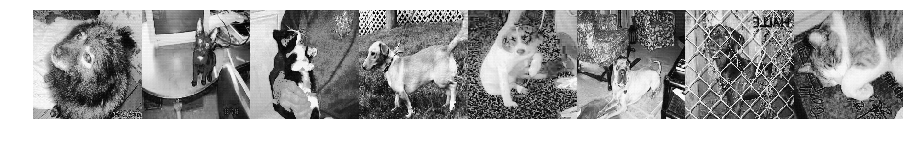

train labels: [ 1.  0.  0.  1.  1.  1.  1.  0.]


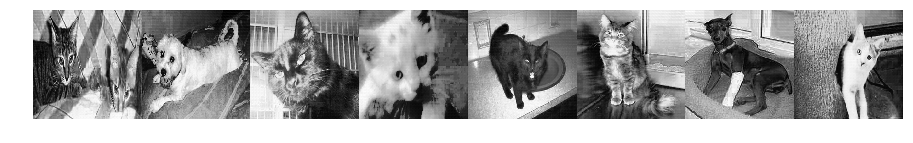

validation labels: [ 0.  1.  0.  0.  0.  0.  1.  0.]


In [19]:
#run just one step of gradient descent for both training and validation nets
solver.net.forward()
solver.test_nets[0].forward() 

#visualize some data from the train net, and their corresponding labels
imgs = solver.net.blobs['data'].data[:8, 0]
imgs_comb = np.hstack((np.asarray(i) for i in imgs))
fig, ax = plt.subplots(figsize=(18, 2))
plt.imshow(imgs_comb, cmap='gray')
plt.axis('off')
plt.show()
print ('train labels: %s') % (solver.net.blobs['label'].data[:8])

#visualize some data from the validation net, and their corresponding labels
imgs = solver.test_nets[0].blobs['data'].data[:8, 0]
imgs_comb = np.hstack((np.asarray(i) for i in imgs))
fig, ax = plt.subplots(figsize=(18, 2))
plt.imshow(imgs_comb, cmap='gray')
plt.axis('off')
plt.show()
print ('validation labels: %s') % (solver.test_nets[0].blobs['label'].data[:8])

As previously promised, here we will restore the solver to a previously stored snapshot. Each time a snapshot is created, it produces two files:  
1 .caffemodel -- this is the output model  
2 .solverstate -- this is the snapshot image

Lets say you wanted to set the solver state to the snapshot corresponding to the 5200th iteration. The code below implements this.

In [20]:
DO_RESTORE = True
if DO_RESTORE:
    snapshot = 'snapshots/_iter_5200.solverstate'
    solver.restore(snapshot)

Almost ready to start training. Just define a few more variables, and some arrays to store intermediate results.

We will run the current model on the validation set every validation_interval iterations to get an idea of the current accuracy. Note that the batch size for validation is 100 (see section 1). There are 25000 total images, of which 5000 are in the validation set. Therefore, we need to run 50 forward passes of the validation net to go through all the data. This logic is explained in the solver.prototxt

In [25]:
validation_interval = 250 #defines how often to test the accuracy on the validation dataset
validation_iter = 50  #this is the value of test_iter in solver.prototxt, and indicates how many forward passes are required to go through all the validation data

#store training loss, validation accuracy
train_loss = []
validation_loss = []
validation_acc = []
loop_count = 0

In the following loop, we train the model. It is configured to run until the accuracy is at least 90%. It's possible that it may never reach that level, or that it may take an extremely long time, so you can always terminate this loop at any time. Based on the value in the solver (section 3), every s.snapshot iterations a snapshot is made and all the arrays holding loss and accuracy information are also saved.

In [26]:
keep_looping = True
while keep_looping:
    #do one iteration
    solver.step(1)  

    #store the train loss after every step of training
    train_loss.extend([solver.net.blobs['loss'].data.tolist()])
    print ('train loss: %f') % (train_loss[-1])
    #calculate the accuracy every validation_iter iterations
    if loop_count % validation_interval == 0:
        print ('iteration %i, testing...') % (loop_count)
        correct = 0.
        total_num_samples = 0.
        for validation_it in range(validation_iter):
            solver.test_nets[0].forward()
            correct = correct + sum(solver.test_nets[0].blobs['fc8'].data.argmax(1) == solver.test_nets[0].blobs['label'].data)
            total_num_samples = total_num_samples + len(solver.test_nets[0].blobs['label'].data)

        validation_acc.extend([correct/total_num_samples])
        validation_loss.extend([solver.test_nets[0].blobs['loss'].data.tolist()])

        print ('validation accuracy: %f') % (validation_acc[-1])
        print ('validation loss: %f') % (validation_loss[-1])

        #save all the arrays to file
        np.save('train_loss.npy', train_loss)
        np.save('validation_loss.npy', validation_loss)
        np.save('validation_acc.npy', validation_acc)

    #keep training until we reach 90% accuracy
    if validation_acc[-1] > 0.9:
        break

    #increment the loop count
    loop_count = loop_count+1
    
    #do this every loop to force iPython to do realtime printing
    sys.stdout.flush()

train loss: 0.140869
iteration 0, testing...
validation accuracy: 0.922600
validation loss: 0.190249


5250 iterations and about 8 hours later...we reached 90% accuracy! Let's take a look at the accuracy and loss curves. First, load the arrays that were saved as npy files. For the validation arrays, these were updated every validation_interval iterations, so create a corresponding index for plotting purposes.

In [27]:
#load the various arrays for plotting
train_loss = np.load('train_loss_orig.npy')
validation_loss = np.load('validation_loss_orig.npy')
validation_acc = np.load('validation_acc_orig.npy')

#validation_loss and validation_acc were appended to the array every validation_interval iterations, whereas train_loss 
#was appended every iteration. so just define an index for the validation arrays for plotting purposes
validation_inds = range(0,len(validation_loss)*validation_interval, validation_interval)

Now do the actual plotting

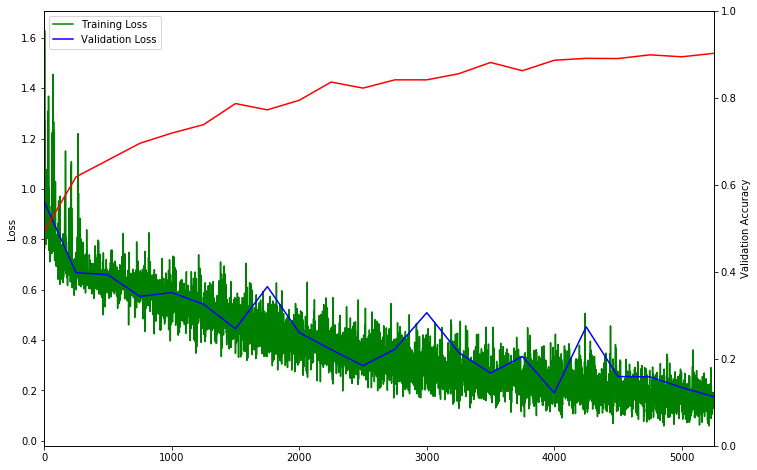

In [28]:
fig, ax1 = plt.subplots(figsize=(12, 8))
ax2 = ax1.twinx()

ax1.plot(train_loss, 'g', label='Training Loss')
ax1.plot(validation_inds, validation_loss, 'b', label='Validation Loss')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper left')

ax2.plot(validation_inds, validation_acc, 'r')
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Validation Accuracy')
plt.axis([0, len(train_loss), 0, 1])

plt.show()

The above curve looks pretty good. There's no evidence of overtraining, in which the accuracy would continue increasing and the training loss would continue decreasing, but the validation loss would increase. It seems we could have continued training to achieve an even higher accuracy, but since we have the snapshot at iteration 5200 we can still do this with no problem.  

If you went through the training, the snapshots directory will have a ton of snapshots. But to save you the hassle, I've included my snapshot for iteration 5200 (iter_5200.caffemodel). We'll work with this model in the next step.

### 6. Test the Net on New Data 

Now that we have a fairly accurate model, let's test it out with some new images of cats and dogs. This a relatively simple process in comparison to all that we've had to do so far. 

We'll load two images -- one of a cat and one of a dog. Each image is preprocessed in the same way we preprocessed the training images. In addition, we subtract the mean image because that was part of the transformation step in the data layers of the training and validation architectures. Basically it boils down to this...for every new image we want to classify, we have to exactly reproduce the conditions of the training images. 

First, we point caffe to the deploy architecture, and load up the model from iteration 5200.   

In [29]:
#set caffe to CPU mode
#define the directories for the model definition and model weights
caffe.set_mode_cpu()

model_def = 'deploy.prototxt'
model_weights = 'snapshots/_iter_5200.caffemodel'

#define the net
net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

Next, define a function to preprocess the image and subtract the mean image

In [30]:
#load the mean image
mean_img = np.load('mean_img.npy')

def prepare_img(img):
    #do histogram equalization to account for contrast. this function expects a grayscale image
    #so do each BGR component separately
    img[:,:,0] = cv2.equalizeHist(img[:,:,0])
    img[:,:,1] = cv2.equalizeHist(img[:,:,1])
    img[:,:,2] = cv2.equalizeHist(img[:,:,2])

    #resize the image
    #TODO: there are many potential complications with resizing an image, and also different approach
    #is better for upscaling or downscaling an image. this can definitly be improved.
    img = cv2.resize(img, (227, 227), interpolation = cv2.INTER_CUBIC)

    #subtract the mean image
    img = img - mean_img

    #reshape to (3,x,y)
    img = np.rollaxis(img, 2)

    return img

Load the two images, and preprocess them

In [31]:
#load images to classify
img1 = cv2.imread('cat1.jpg', cv2.IMREAD_COLOR)
img2 = cv2.imread('dog1.jpg', cv2.IMREAD_COLOR)

#resize the input images to match the input size of the net and subtract the mean image
#also redefine the axes from (x,y,3) to (3,x,y) 
img1 = prepare_img(img1)
img2 = prepare_img(img2)

#combine these two images together into an array of dimension (100,3,227,227) 
#note that 100 is the batch size for deploy architecture
imgs = np.zeros(shape=(100,3,227,227))
imgs[0] = img1
imgs[1] = img2

Now, do the actual classification. The first step is to put the images into the memory allocated for the net. Recall that our batch size for deployment is 100, which is why we defined our "imgs" array to be of size 100. So we could have stacked up to 100 images into the "imgs" array and classified them all at the same time.  

Run forward prop to get the output probabilities.

In [32]:
net.blobs['data'].data[...] = imgs
net_output = net.forward()

net_output is a dictionary, and the probabilities are stored in the key "prob". The key is called "prob" because in our deploy architecture, the last layer (the softmax layer) is named "prob".    

Let's take a look at the first 10 results

In [33]:
print net_output['prob'][0:10]

[[  9.99868989e-01   1.31013920e-04]
 [  3.83524485e-02   9.61647511e-01]
 [  8.11716259e-01   1.88283682e-01]
 [  8.11716259e-01   1.88283682e-01]
 [  8.11716259e-01   1.88283682e-01]
 [  8.11716259e-01   1.88283682e-01]
 [  8.11716259e-01   1.88283682e-01]
 [  8.11716259e-01   1.88283682e-01]
 [  8.11716259e-01   1.88283682e-01]
 [  8.11716259e-01   1.88283682e-01]]


Sweet! Our first image has a 0.999 probability of being a cat (label 0) and our second image has a 0.962 probability of being at dog (label 1). So it's working pretty darn well.  

Note that the remaining outputs are all garbage and can be ignored. If you only plan to classify a single image in your deploy architecture, you can just change the batch_size for deployment to be 1 (or whatever other value you need). 

### 7. Conclusion

Following the above steps, we've gone through the entire process of obtaining images for training, creating databases for training and validation, defining network architectures, training a network with high accuracy, and testing new unlabeled images.  

You can take this framework and apply it to any other classification problem you'd like to solve. There are definitely many adjustments and improvements you can make, depending on the problem you're trying to solve.  

First, good image preprocessing can make a big difference. In the case of OCR analysis, deskewing the image as a preprocessing step has major benefits. In other cases with high frequency noise, perhaps a lowpass filter would help. You'll have to be creative and most likely determine the best conditions through trial and error.

Second, choosing the right network architecture is important. There are lots of really powerful and well researched architectures out there. Each one has its advantages and disadvantages, and most likely some architectures perform optimally for certain types of data versus other types of data. For example, a complex problem such as a cat versus dog classifier would probably perform poorly in a tiny architecture (ie, a network with only one convolution layer). 

Lastly, setting the solver parameters can make or break your training. If your learning rate is too high, the solver may spiral out of control and crash. If you set the learning rate too low, it may take unreasonably long to get a good accuracy. Choosing the type of solver (such as SGD vs Adam) and its corresponding parameters is also important. Fortunately there are a lot of good examples out there to get you started.